In [1]:
import time
import random
import numpy as np
import pandas as pd
import sys
import pickle
import h5py
import copy
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'
import torch
import learn2learn as l2l
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter
from torch.optim.lr_scheduler import StepLR, CosineAnnealingLR
from functions.fftc import fft2c_new as fft2c
from functions.fftc import ifft2c_new as ifft2c
from functions.math import complex_abs, complex_mul, complex_conj
# The corase reconstruction is the rss of the zerofilled multi-coil kspaces
# after inverse FT.
from functions.data.transforms import UnetDataTransform_TTTpaper_fixMask, center_crop, scale_rss, normalize_separate_over_ch, rss_torch
# Import a torch.utils.data.Dataset class that takes a list of data examples, a path to those examples
# a data transform and outputs a torch dataset.
from functions.data.mri_dataset import SliceDataset
# Unet architecture as nn.Module
from functions.models.unet import Unet
# Function that returns a MaskFunc object either for generatig random or equispaced masks
from functions.data.subsample import create_mask_for_mask_type
# Implementation of SSIMLoss
from functions.training.losses import SSIMLoss
from functions.helper import evaluate2c_imagepair
### after you install bart 0.7.00 from https://mrirecon.github.io/bart/, import it as follows
sys.path.insert(0,'/cheng/bart-0.7.00/python/')
os.environ['TOOLBOX_PATH'] = "/cheng/bart-0.7.00/"
import bart


plt.rcParams.update({"text.usetex": True, "font.family": "serif", "font.serif": ["Computer Modern Roman"]})

colors = ['b','r','k','g','m','c','tab:brown','tab:orange','tab:pink','tab:gray','tab:olive','tab:purple']

markers = ["v","o","^","1","*",">","d","<","s","P","X"]
FONTSIZE = 22

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# seed
SEED = 1
random.seed(SEED)
np.random.seed(SEED)
torch.cuda.manual_seed(SEED)
torch.manual_seed(SEED)


### Load the data

In [2]:
# data path
path_test = '/cheng/metaMRI/metaMRI/data_dict/TTT_paper/TTT_brain_val.yaml'
path_test_sensmaps = '/cheng/metaMRI/metaMRI/data_dict/TTT_paper/sensmap_brain_val/'

# path_test = '/cheng/metaMRI/metaMRI/data_dict/TTT_paper/TTT_brain_test_100.yaml'
# path_test_sensmaps = '/cheng/metaMRI/metaMRI/data_dict/TTT_paper/sensmap_brain_test/'

# data transform
data_transform = UnetDataTransform_TTTpaper_fixMask('multicoil')

# training dataset and data loader
testset = SliceDataset(dataset = path_test, path_to_dataset='', 
                path_to_sensmaps = path_test_sensmaps, provide_senmaps=True, 
                challenge="multicoil", transform = data_transform, use_dataset_cache=True)

# shuffle = False !!!!!!!
test_dataloader = torch.utils.data.DataLoader(dataset = testset, batch_size = 1, 
                shuffle = False, generator = torch.Generator().manual_seed(1), pin_memory = False)


In [3]:
path_mask = '/cheng/metaMRI/ttt_for_deep_learning_cs/unet/test_data/anatomy_shift/mask2d'
with open(path_mask,'rb') as fn:
    mask2d = pickle.load(fn)
mask = torch.tensor(mask2d[0]).unsqueeze(0).unsqueeze(0).unsqueeze(-1)
mask = mask.to(device)

In [4]:
ssim_fct = SSIMLoss()
l1_loss = torch.nn.L1Loss(reduction='sum')
iterator = iter(test_dataloader)
batch = next(iterator)
origk, sens_maps, sens_maps_conj, _, fname, slice_num = batch
fname

('file_brain_AXT2_200_2000501',)

In [5]:
def TTT(model, origk, sens_maps):
    adapt_lr = 0.00001
    TTT_epoch = 1500
    # each data point TTT


    origk = origk.squeeze(0).to(device)
    sens_maps = sens_maps.squeeze(0).to(device)
    #sens_maps_conj = sens_maps_conj.squeeze(0).to(device)

    # input k space
    input_kspace = origk * mask + 0.0
    # scale factor
    scale_factor = scale_rss(input_kspace, model)
    scale_input_kspace = scale_factor * input_kspace # [coils,height,width,2]

    # gt image by normalized kspace: x
    target_image_1c = rss_torch(complex_abs(ifft2c(origk))).unsqueeze(0)
    # sensmap combine
    # target_image = complex_mul(target_image, sens_maps_conj).sum(dim=0, keepdim=False)
    crop_size = torch.Size([min(target_image_1c.shape[-2:]), min(target_image_1c.shape[-2:])])
    crop_target_image = center_crop( target_image_1c, crop_size )
    std_crop_target_image = crop_target_image.std()
    mean_crop_target_image = crop_target_image.mean()

    # A†y
    # train_inputs = complex_mul(train_inputs, sens_maps_conj).sum(dim=0, keepdim=False) #shape: height,width,2
    train_inputs = torch.moveaxis(rss_torch(ifft2c(scale_input_kspace)), -1, 0)   # [2, height, width]

    loss_l1_history = []
    loss_ssim_history = []
    self_loss_history = []
    model_ttt = copy.deepcopy(model)
    optimizer = torch.optim.Adam(model_ttt.parameters(),lr=adapt_lr)

    for iteration in range(TTT_epoch): 
        ###### training ######
        # fθ(A†y)
        model_output = model_ttt(train_inputs.unsqueeze(0))    # [1, 2, height, width]       
        # S fθ(A†y) [coils, height, width, channel]
        #output_sens_image = complex_mul(torch.moveaxis(model_output.unsqueeze(0), 1, -1 ), sens_maps)

        output_sens_image = torch.zeros(sens_maps.shape).to(device) 
        model_output = torch.moveaxis(model_output, 1, -1 )    #[1, height, width, 2]
        for j,s in enumerate(sens_maps):
            ss = s.clone()
            ss[torch.abs(ss)==0.0] = torch.abs(ss).max()
            output_sens_image[j,:,:,0] = model_output[0,:,:,0] * ss[:,:,0] - model_output[0,:,:,1] * ss[:,:,1]
            output_sens_image[j,:,:,1] = model_output[0,:,:,0] * ss[:,:,1] + model_output[0,:,:,1] * ss[:,:,0]

        # FS fθ(A†y)
        Fimg = fft2c(output_sens_image)
        # MFS fθ(A†y) = A fθ(A†y)
        Fimg_forward = Fimg * mask
        # consistency loss [y, Afθ(A†y)]
        loss_self = l1_loss(Fimg_forward, scale_input_kspace) / torch.sum(torch.abs(scale_input_kspace))

        optimizer.zero_grad()
        loss_self.backward()
        optimizer.step()
        #train_loss += loss.item()
        #print('TTT loss: ',loss_self.item())
        self_loss_history.append(loss_self.item())

        ###### evaluation ######
        output_image_1c = complex_abs(model_output).unsqueeze(0)    # [2, height, width] -> [1, height, width]
        # center crop for SSIM
        crop_output_image = center_crop( output_image_1c, crop_size )
        # normalization
        crop_output_image = (crop_output_image - crop_output_image.mean()) / crop_output_image.std()
        crop_output_image *= std_crop_target_image
        crop_output_image += mean_crop_target_image
        # SSIM = 1 - loss
        loss_ssim = 1 - ssim_fct(crop_output_image, crop_target_image, data_range = crop_target_image.max().unsqueeze(0)).item()
        print(f"Epoch {iteration+1}/{TTT_epoch}, Loss: {loss_self.item():.4f}", end='\r')
        print(f"Epoch {iteration+1}/{TTT_epoch}, SSIM: {loss_ssim:.4f}", end='\r')

        #loss_l1_history.append(loss_l1)
        loss_ssim_history.append(loss_ssim)

    # best results for an example
    # best_loss_l1 = min(loss_l1_history)
    # print('The best L1: ', best_loss_l1)
    # best_loss_l1_epoch = np.argmin(loss_l1_history)
    # print('The best L1 epoch: ', best_loss_l1_epoch)
    best_loss_ssim = max(loss_ssim_history)
    print('The best SSIM through training process:', best_loss_ssim)
    best_loss_ssim_epoch = np.argmax(loss_ssim_history)
    print('The best SSIM epoch: ', best_loss_ssim_epoch)
    return self_loss_history,loss_ssim_history, best_loss_ssim_epoch

### Test-time training
 - joint loss train on P test on Q (300 epoch)
 - MAML inner self loss outer joint loss train on P test on Q (300+34 epoch)

In [6]:
checkpoint_path = '/cheng/metaMRI/metaMRI/save/E12.1_joint(l1_1e-5)P_T300_300epoch/E_12.1_joint(l1_1e-5)P_T300_300epoch_E300_best.pth'
model = Unet(in_chans=2, out_chans=2, chans=64, num_pool_layers=4, drop_prob=0.0)
model.load_state_dict(torch.load(checkpoint_path))
model = model.to(device)

checkpoint_path_meta = '/cheng/metaMRI/metaMRI/save/E12.2_maml(l1_-5)P_T300_from300epoch/E12.2_maml(l1_-5)P_T300_from300epoch_E400.pth'
model_meta = Unet(in_chans=2, out_chans=2, chans=64, num_pool_layers=4, drop_prob=0.0)
model_meta.load_state_dict(torch.load(checkpoint_path_meta))
model_meta = model_meta.to(device)

In [7]:
self_loss_history, loss_ssim_history, best_loss_ssim_epoch = TTT(model, origk, sens_maps)
self_loss_history_meta, loss_ssim_history_meta, best_loss_ssim_epoch_meta = TTT(model_meta, origk, sens_maps)

The best SSIM through training process: 0.944618284702301
The best SSIM epoch:  1492
The best SSIM through training process: 0.9452313780784607
The best SSIM epoch:  1467


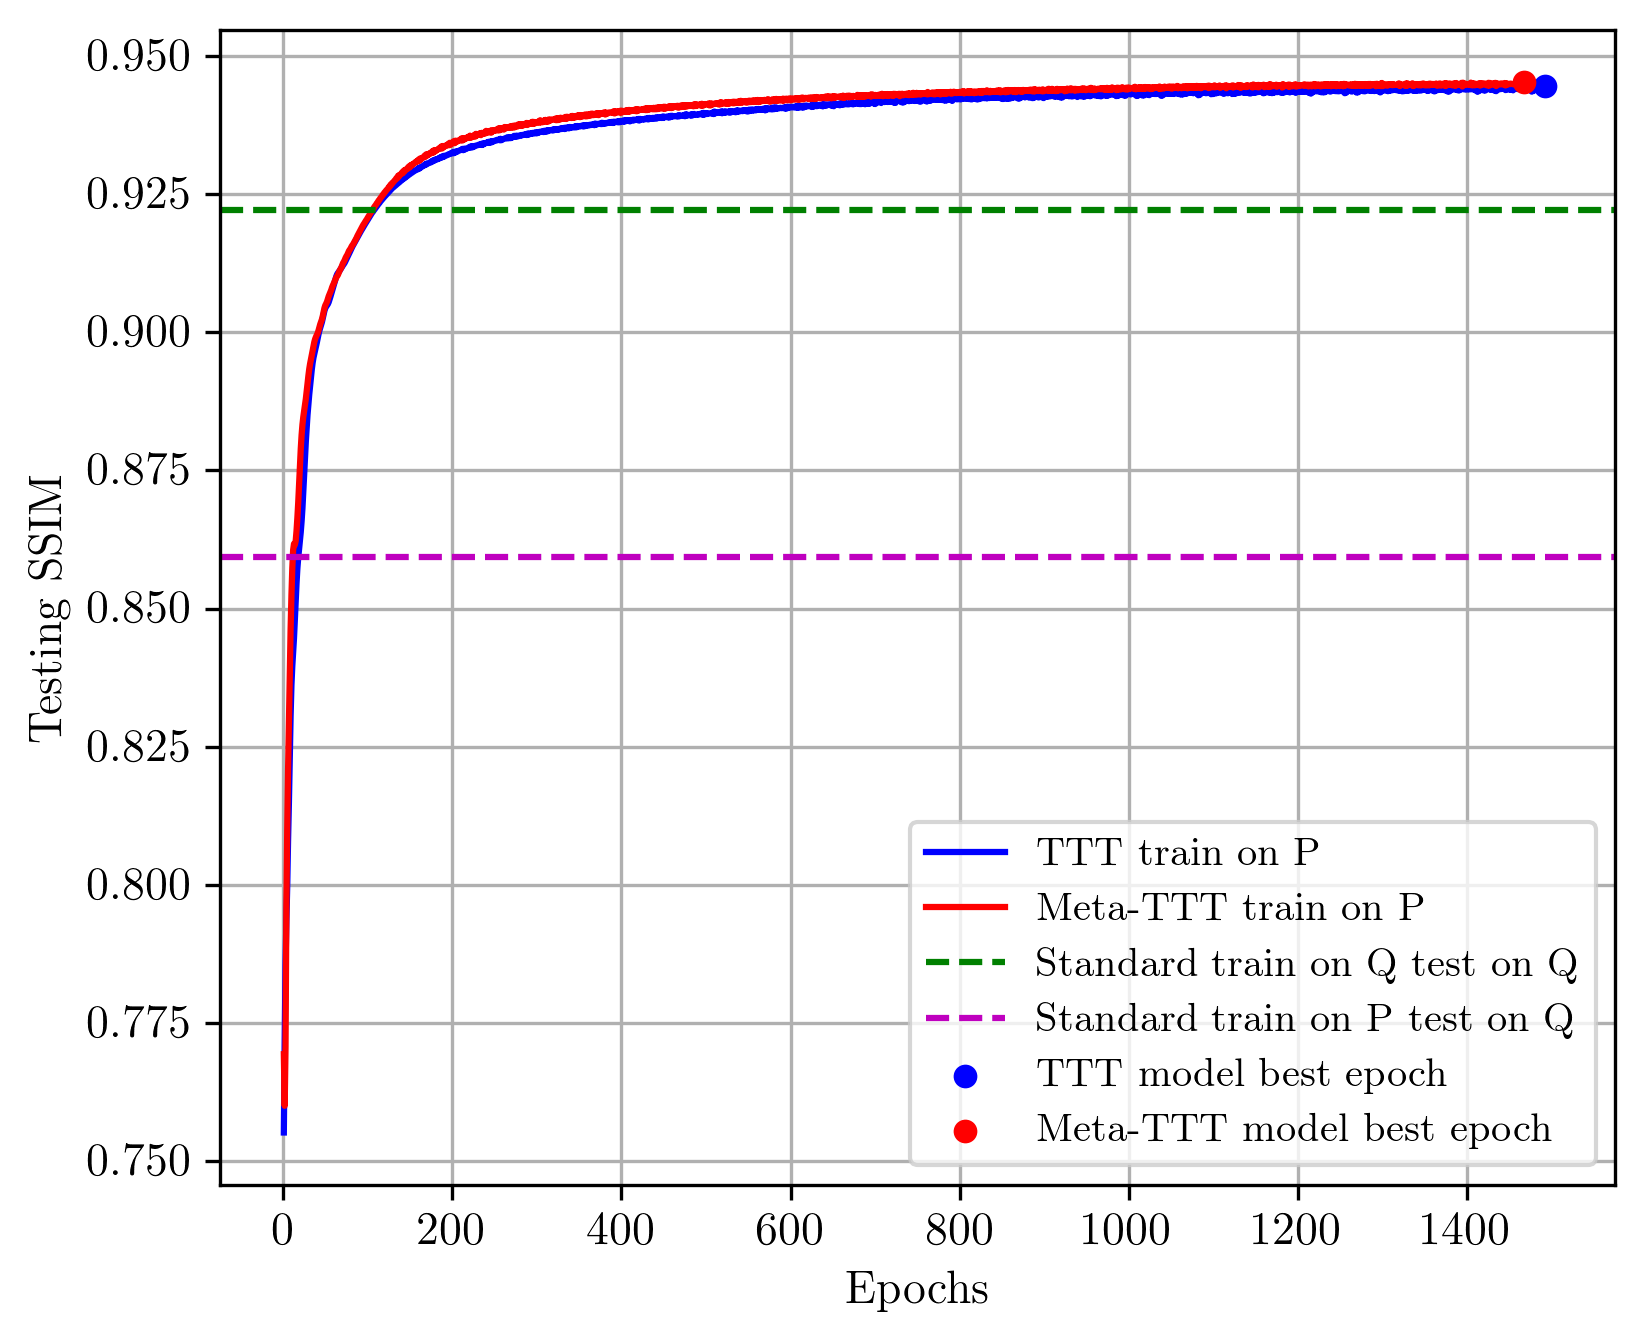

In [8]:
TTT_epoch = 1500
upper_bound = 0.9222 # not real
lower_bound = 0.8593 # not real

plt.figure(figsize=(6,5),dpi=300)
plt.grid(True, zorder=1)    # grid on bottom
# alpha: transparency 
plt.plot(range(1, TTT_epoch+1), loss_ssim_history, color=colors[0], label='TTT train on P')
plt.plot(range(1, TTT_epoch+1), loss_ssim_history_meta, color=colors[1], label='Meta-TTT train on P ')

plt.axhline(y = upper_bound, color=colors[3], linestyle='--', label='Standard train on Q test on Q ')   # upper bound
# plt.text(x=850, y=upper_bound+0.005, s='upper bound', color=colors[2])
plt.axhline(y = lower_bound, color=colors[4], linestyle='--', label='Standard train on P test on Q ')   # upper bound

plt.scatter(best_loss_ssim_epoch, loss_ssim_history[best_loss_ssim_epoch], color=colors[0], s=FONTSIZE, label = 'TTT model best epoch', zorder=2)
plt.scatter(best_loss_ssim_epoch_meta, loss_ssim_history_meta[best_loss_ssim_epoch_meta], color=colors[1], s=FONTSIZE, label = 'Meta-TTT model best epoch', zorder=2)

plt.tick_params(axis='both', which='major', labelsize=FONTSIZE/2)
plt.tick_params(axis='both', which='minor', labelsize=(FONTSIZE-2)/2)
plt.xlabel('Epochs',fontsize=FONTSIZE/2)
plt.ylabel('Testing SSIM',fontsize=FONTSIZE/2)
#plt.title('Out-of-distribution Q3 Adaptation', fontsize = FONTSIZE/2)
plt.legend(fontsize = (FONTSIZE-3)/2)

plt.show()

### Test-time training
 - joint loss train on P test on Q (300 epoch)
 - MAML inner self loss outer joint loss train on P test on Q (300 epoch)

In [9]:
checkpoint_path = '/cheng/metaMRI/metaMRI/save/E12.1_joint(l1_1e-5)P_T300_300epoch/E_12.1_joint(l1_1e-5)P_T300_300epoch_E300_best.pth'
model = Unet(in_chans=2, out_chans=2, chans=64, num_pool_layers=4, drop_prob=0.0)
model.load_state_dict(torch.load(checkpoint_path))
model = model.to(device)

checkpoint_path_meta = '/cheng/metaMRI/metaMRI/save/E12.1_maml(l1_-5)P_T300_300epoch/E12.1_maml(l1_-5)P_T300_300epoch_E300.pth'
model_meta = Unet(in_chans=2, out_chans=2, chans=64, num_pool_layers=4, drop_prob=0.0)
model_meta.load_state_dict(torch.load(checkpoint_path_meta))
model_meta = model_meta.to(device)

In [10]:
self_loss_history, loss_ssim_history, best_loss_ssim_epoch = TTT(model, origk, sens_maps)
self_loss_history_meta, loss_ssim_history_meta, best_loss_ssim_epoch_meta = TTT(model_meta, origk, sens_maps)

The best SSIM through training process: 0.9445289969444275
The best SSIM epoch:  1462
The best SSIM through training process: 0.9367291331291199
The best SSIM epoch:  1452


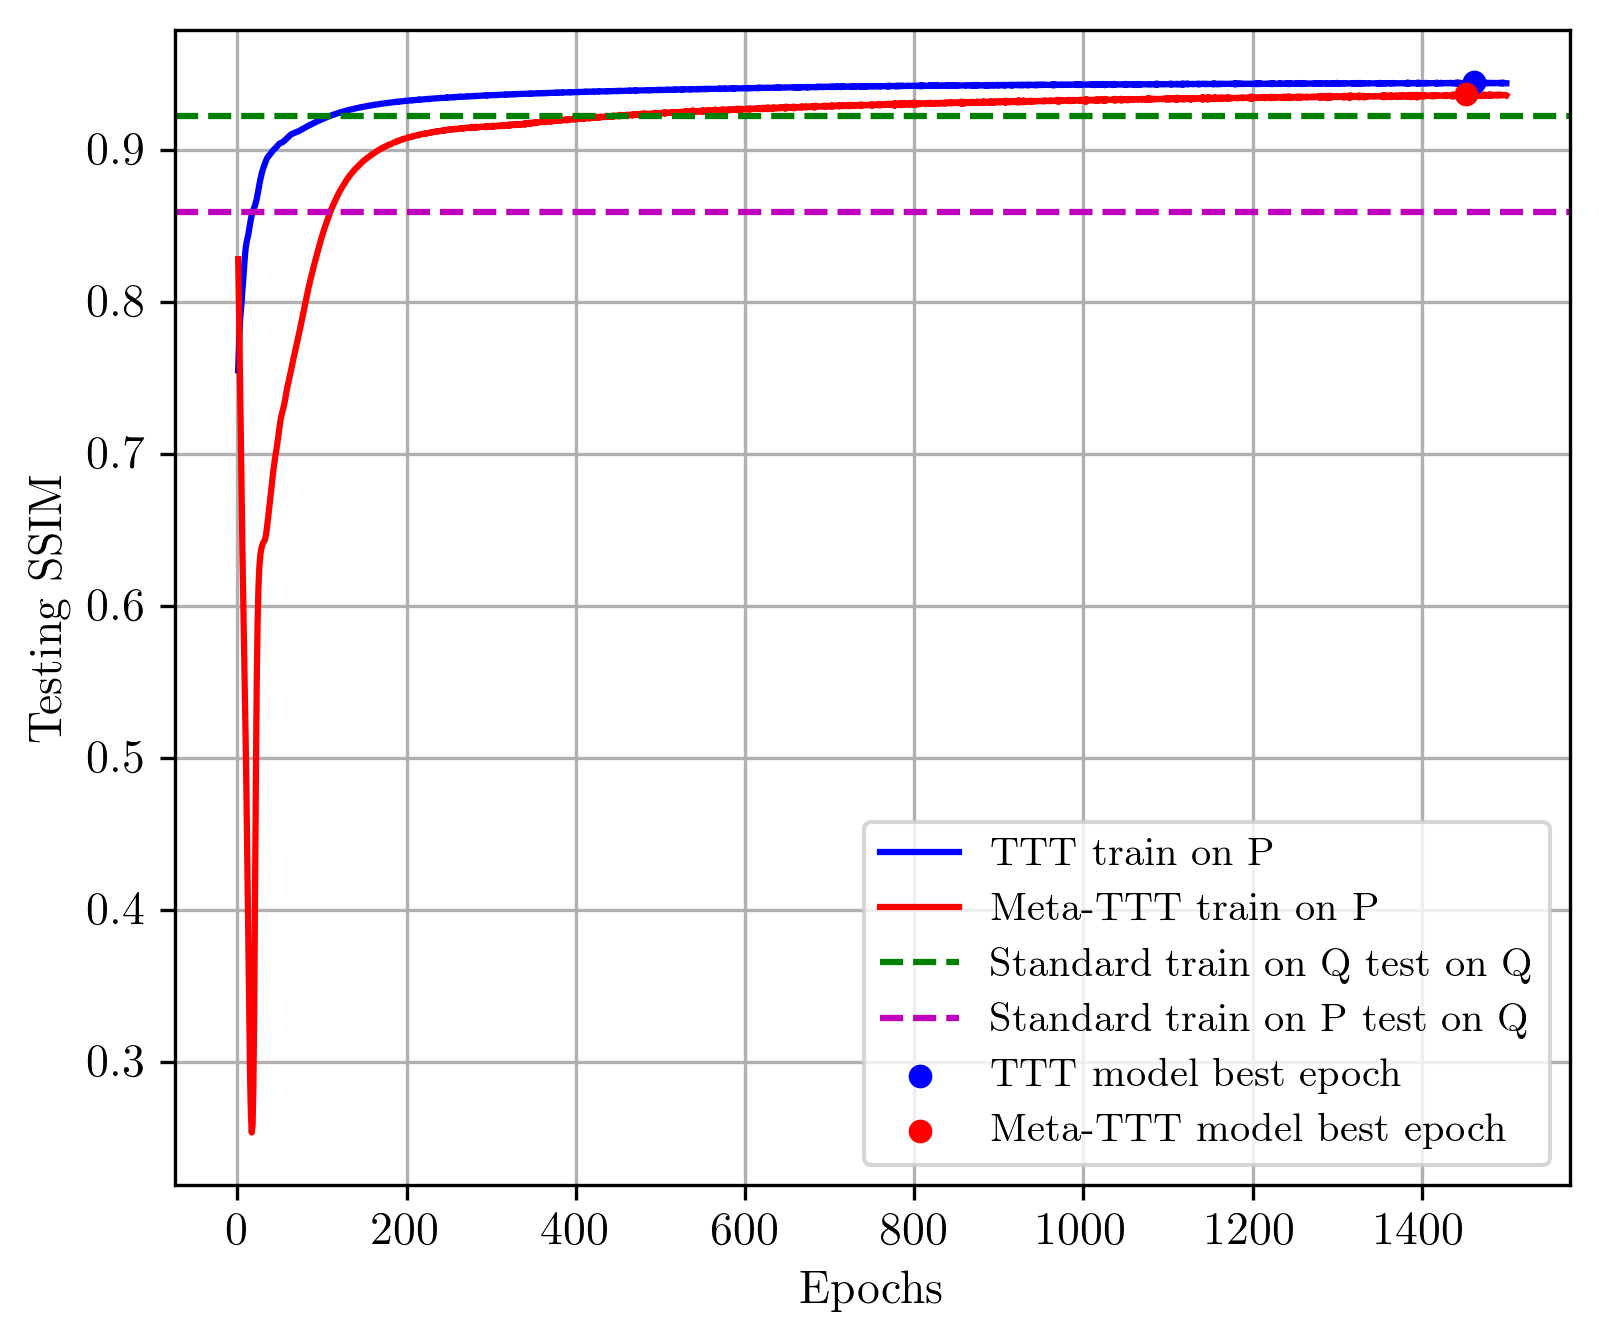

In [11]:
TTT_epoch = 1500
upper_bound = 0.9222 # not real
lower_bound = 0.8593 # not real

plt.figure(figsize=(6,5),dpi=300)
plt.grid(True, zorder=1)    # grid on bottom
# alpha: transparency 
plt.plot(range(1, TTT_epoch+1), loss_ssim_history, color=colors[0], label='TTT train on P')
plt.plot(range(1, TTT_epoch+1), loss_ssim_history_meta, color=colors[1], label='Meta-TTT train on P ')

plt.axhline(y = upper_bound, color=colors[3], linestyle='--', label='Standard train on Q test on Q ')   # upper bound
# plt.text(x=850, y=upper_bound+0.005, s='upper bound', color=colors[2])
plt.axhline(y = lower_bound, color=colors[4], linestyle='--', label='Standard train on P test on Q ')   # upper bound

plt.scatter(best_loss_ssim_epoch, loss_ssim_history[best_loss_ssim_epoch], color=colors[0], s=FONTSIZE, label = 'TTT model best epoch', zorder=2)
plt.scatter(best_loss_ssim_epoch_meta, loss_ssim_history_meta[best_loss_ssim_epoch_meta], color=colors[1], s=FONTSIZE, label = 'Meta-TTT model best epoch', zorder=2)

plt.tick_params(axis='both', which='major', labelsize=FONTSIZE/2)
plt.tick_params(axis='both', which='minor', labelsize=(FONTSIZE-2)/2)
plt.xlabel('Epochs',fontsize=FONTSIZE/2)
plt.ylabel('Testing SSIM',fontsize=FONTSIZE/2)
#plt.title('Out-of-distribution Q3 Adaptation', fontsize = FONTSIZE/2)
plt.legend(fontsize = (FONTSIZE-3)/2)

plt.show()

In [12]:
checkpoint_path = '/cheng/metaMRI/metaMRI/save/E12.1_joint(l1_1e-5)P_T300_300epoch/E_12.1_joint(l1_1e-5)P_T300_300epoch_E300_best.pth'
model = Unet(in_chans=2, out_chans=2, chans=64, num_pool_layers=4, drop_prob=0.0)
model.load_state_dict(torch.load(checkpoint_path))
model = model.to(device)

checkpoint_path_meta = '/cheng/metaMRI/metaMRI/save/E12.1_maml(l1_-5)P_T300_300epoch/E12.1_maml(l1_-5)P_T300_300epoch_E150.pth'
model_meta = Unet(in_chans=2, out_chans=2, chans=64, num_pool_layers=4, drop_prob=0.0)
model_meta.load_state_dict(torch.load(checkpoint_path_meta))
model_meta = model_meta.to(device)

In [13]:
self_loss_history, loss_ssim_history, best_loss_ssim_epoch = TTT(model, origk, sens_maps)
self_loss_history_meta, loss_ssim_history_meta, best_loss_ssim_epoch_meta = TTT(model_meta, origk, sens_maps)

The best SSIM through training process: 0.9445047974586487
The best SSIM epoch:  1354
The best SSIM through training process: 0.9404006600379944
The best SSIM epoch:  1491


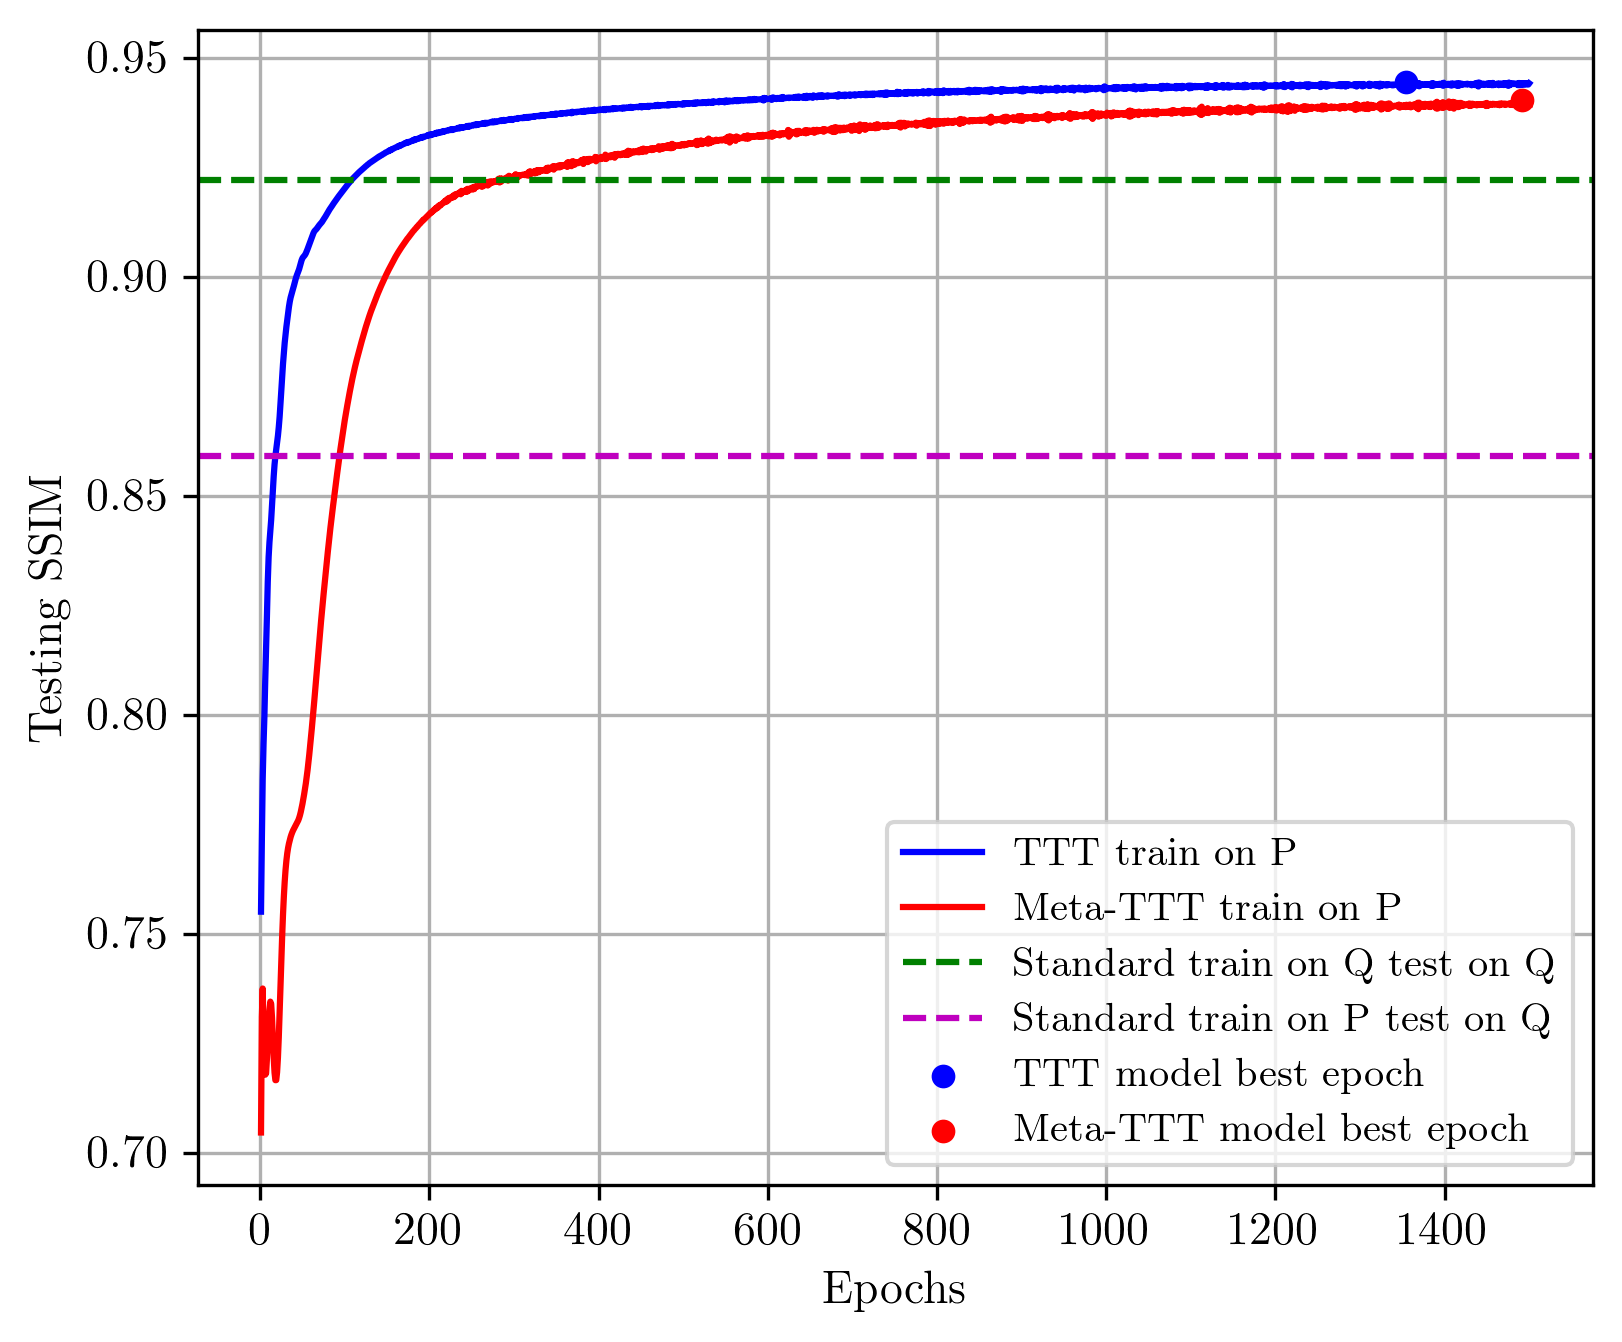

In [14]:
TTT_epoch = 1500
upper_bound = 0.9222 # not real
lower_bound = 0.8593 # not real

plt.figure(figsize=(6,5),dpi=300)
plt.grid(True, zorder=1)    # grid on bottom
# alpha: transparency 
plt.plot(range(1, TTT_epoch+1), loss_ssim_history, color=colors[0], label='TTT train on P')
plt.plot(range(1, TTT_epoch+1), loss_ssim_history_meta, color=colors[1], label='Meta-TTT train on P ')

plt.axhline(y = upper_bound, color=colors[3], linestyle='--', label='Standard train on Q test on Q ')   # upper bound
# plt.text(x=850, y=upper_bound+0.005, s='upper bound', color=colors[2])
plt.axhline(y = lower_bound, color=colors[4], linestyle='--', label='Standard train on P test on Q ')   # upper bound

plt.scatter(best_loss_ssim_epoch, loss_ssim_history[best_loss_ssim_epoch], color=colors[0], s=FONTSIZE, label = 'TTT model best epoch', zorder=2)
plt.scatter(best_loss_ssim_epoch_meta, loss_ssim_history_meta[best_loss_ssim_epoch_meta], color=colors[1], s=FONTSIZE, label = 'Meta-TTT model best epoch', zorder=2)

plt.tick_params(axis='both', which='major', labelsize=FONTSIZE/2)
plt.tick_params(axis='both', which='minor', labelsize=(FONTSIZE-2)/2)
plt.xlabel('Epochs',fontsize=FONTSIZE/2)
plt.ylabel('Testing SSIM',fontsize=FONTSIZE/2)
#plt.title('Out-of-distribution Q3 Adaptation', fontsize = FONTSIZE/2)
plt.legend(fontsize = (FONTSIZE-3)/2)

plt.show()

In [16]:
checkpoint_path_meta = '/cheng/metaMRI/metaMRI/save/E12.1_maml(l1_-5)P_T300_300epoch/E12.1_maml(l1_-5)P_T300_300epoch_E200.pth'
model_meta = Unet(in_chans=2, out_chans=2, chans=64, num_pool_layers=4, drop_prob=0.0)
model_meta.load_state_dict(torch.load(checkpoint_path_meta))
model_meta = model_meta.to(device)
self_loss_history_meta, loss_ssim_history_meta, best_loss_ssim_epoch_meta = TTT(model_meta, origk, sens_maps)

The best SSIM through training process: 0.9405953288078308
The best SSIM epoch:  1480


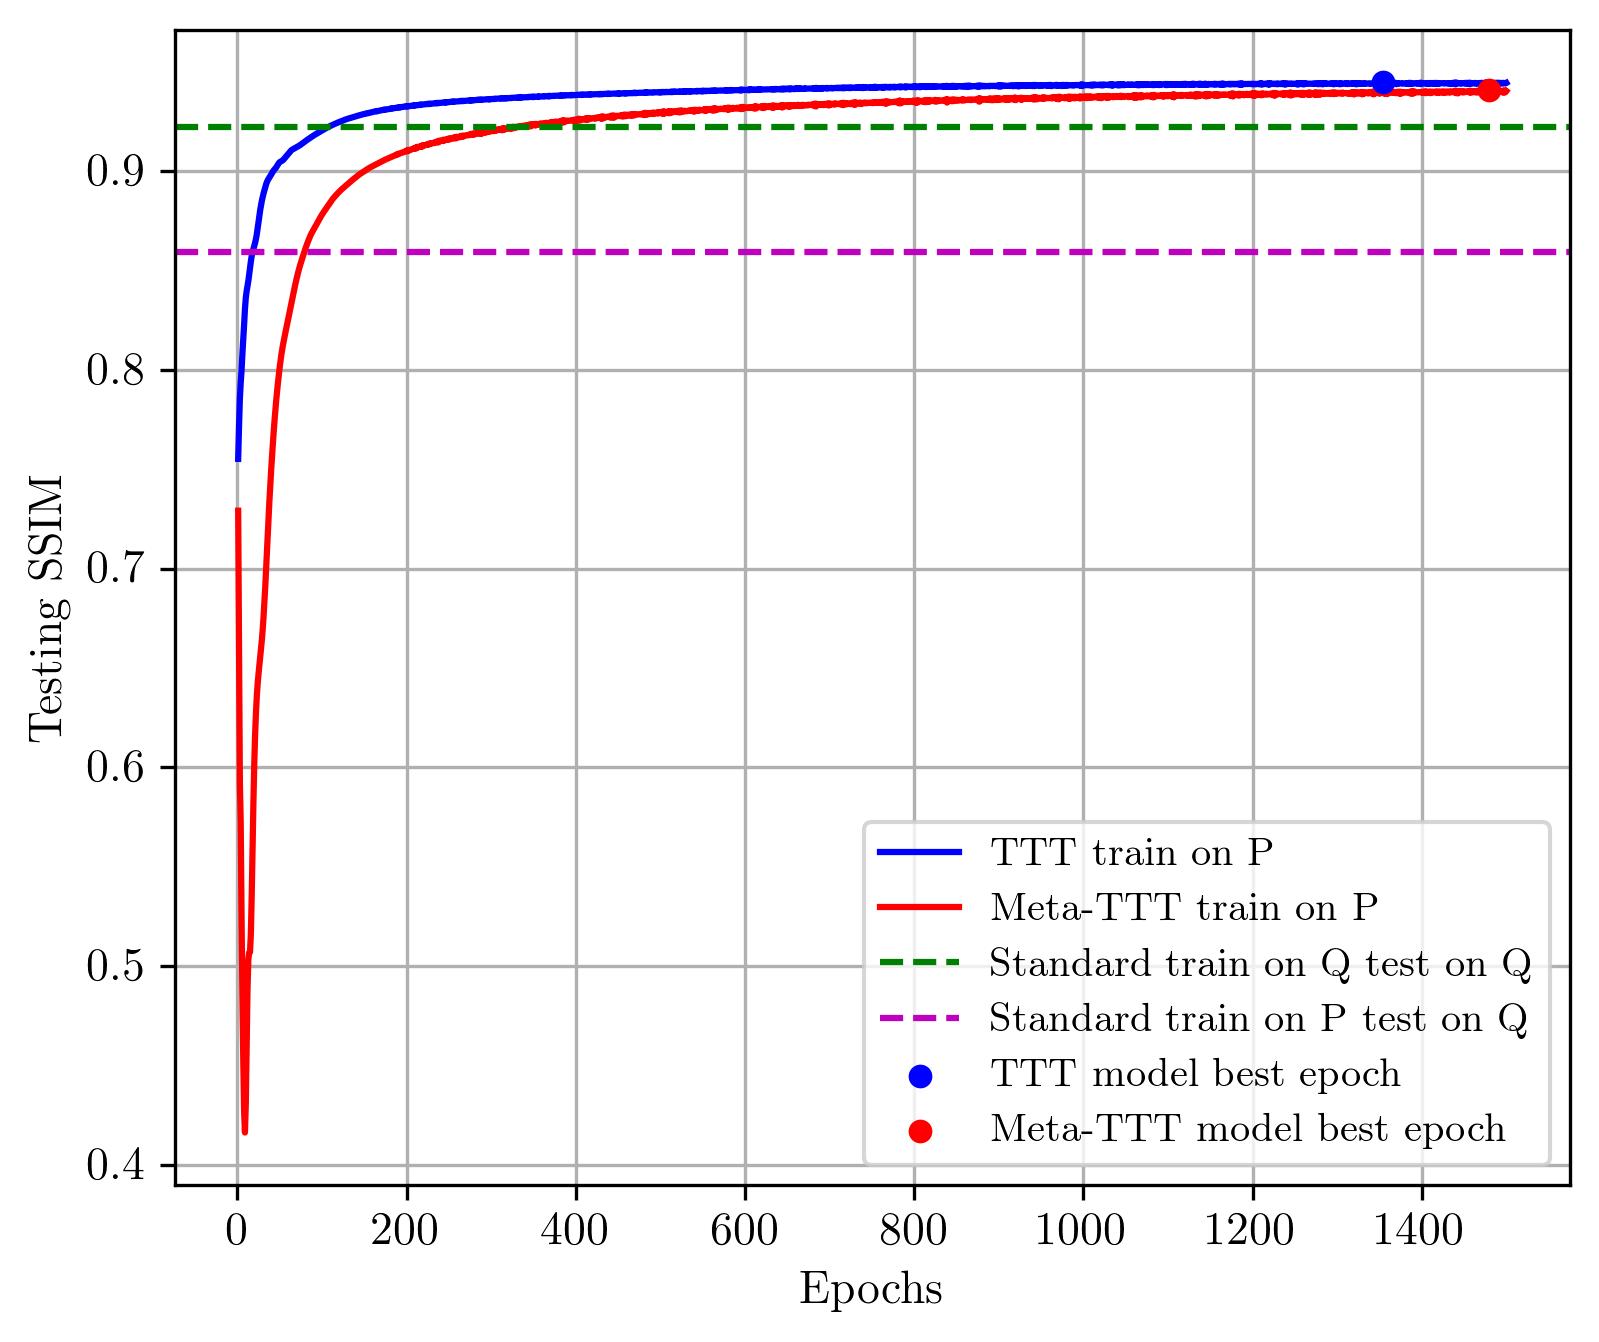

In [17]:
TTT_epoch = 1500
upper_bound = 0.9222 # not real
lower_bound = 0.8593 # not real

plt.figure(figsize=(6,5),dpi=300)
plt.grid(True, zorder=1)    # grid on bottom
# alpha: transparency 
plt.plot(range(1, TTT_epoch+1), loss_ssim_history, color=colors[0], label='TTT train on P')
plt.plot(range(1, TTT_epoch+1), loss_ssim_history_meta, color=colors[1], label='Meta-TTT train on P ')

plt.axhline(y = upper_bound, color=colors[3], linestyle='--', label='Standard train on Q test on Q ')   # upper bound
# plt.text(x=850, y=upper_bound+0.005, s='upper bound', color=colors[2])
plt.axhline(y = lower_bound, color=colors[4], linestyle='--', label='Standard train on P test on Q ')   # upper bound

plt.scatter(best_loss_ssim_epoch, loss_ssim_history[best_loss_ssim_epoch], color=colors[0], s=FONTSIZE, label = 'TTT model best epoch', zorder=2)
plt.scatter(best_loss_ssim_epoch_meta, loss_ssim_history_meta[best_loss_ssim_epoch_meta], color=colors[1], s=FONTSIZE, label = 'Meta-TTT model best epoch', zorder=2)

plt.tick_params(axis='both', which='major', labelsize=FONTSIZE/2)
plt.tick_params(axis='both', which='minor', labelsize=(FONTSIZE-2)/2)
plt.xlabel('Epochs',fontsize=FONTSIZE/2)
plt.ylabel('Testing SSIM',fontsize=FONTSIZE/2)
#plt.title('Out-of-distribution Q3 Adaptation', fontsize = FONTSIZE/2)
plt.legend(fontsize = (FONTSIZE-3)/2)

plt.show()

In [18]:
checkpoint_path_meta = '/cheng/metaMRI/metaMRI/save/E12.1_maml(l1_-5)P_T300_300epoch/E12.1_maml(l1_-5)P_T300_300epoch_E250.pth'
model_meta = Unet(in_chans=2, out_chans=2, chans=64, num_pool_layers=4, drop_prob=0.0)
model_meta.load_state_dict(torch.load(checkpoint_path_meta))
model_meta = model_meta.to(device)
self_loss_history_meta, loss_ssim_history_meta, best_loss_ssim_epoch_meta = TTT(model_meta, origk, sens_maps)

The best SSIM through training process: 0.9401347041130066
The best SSIM epoch:  1472


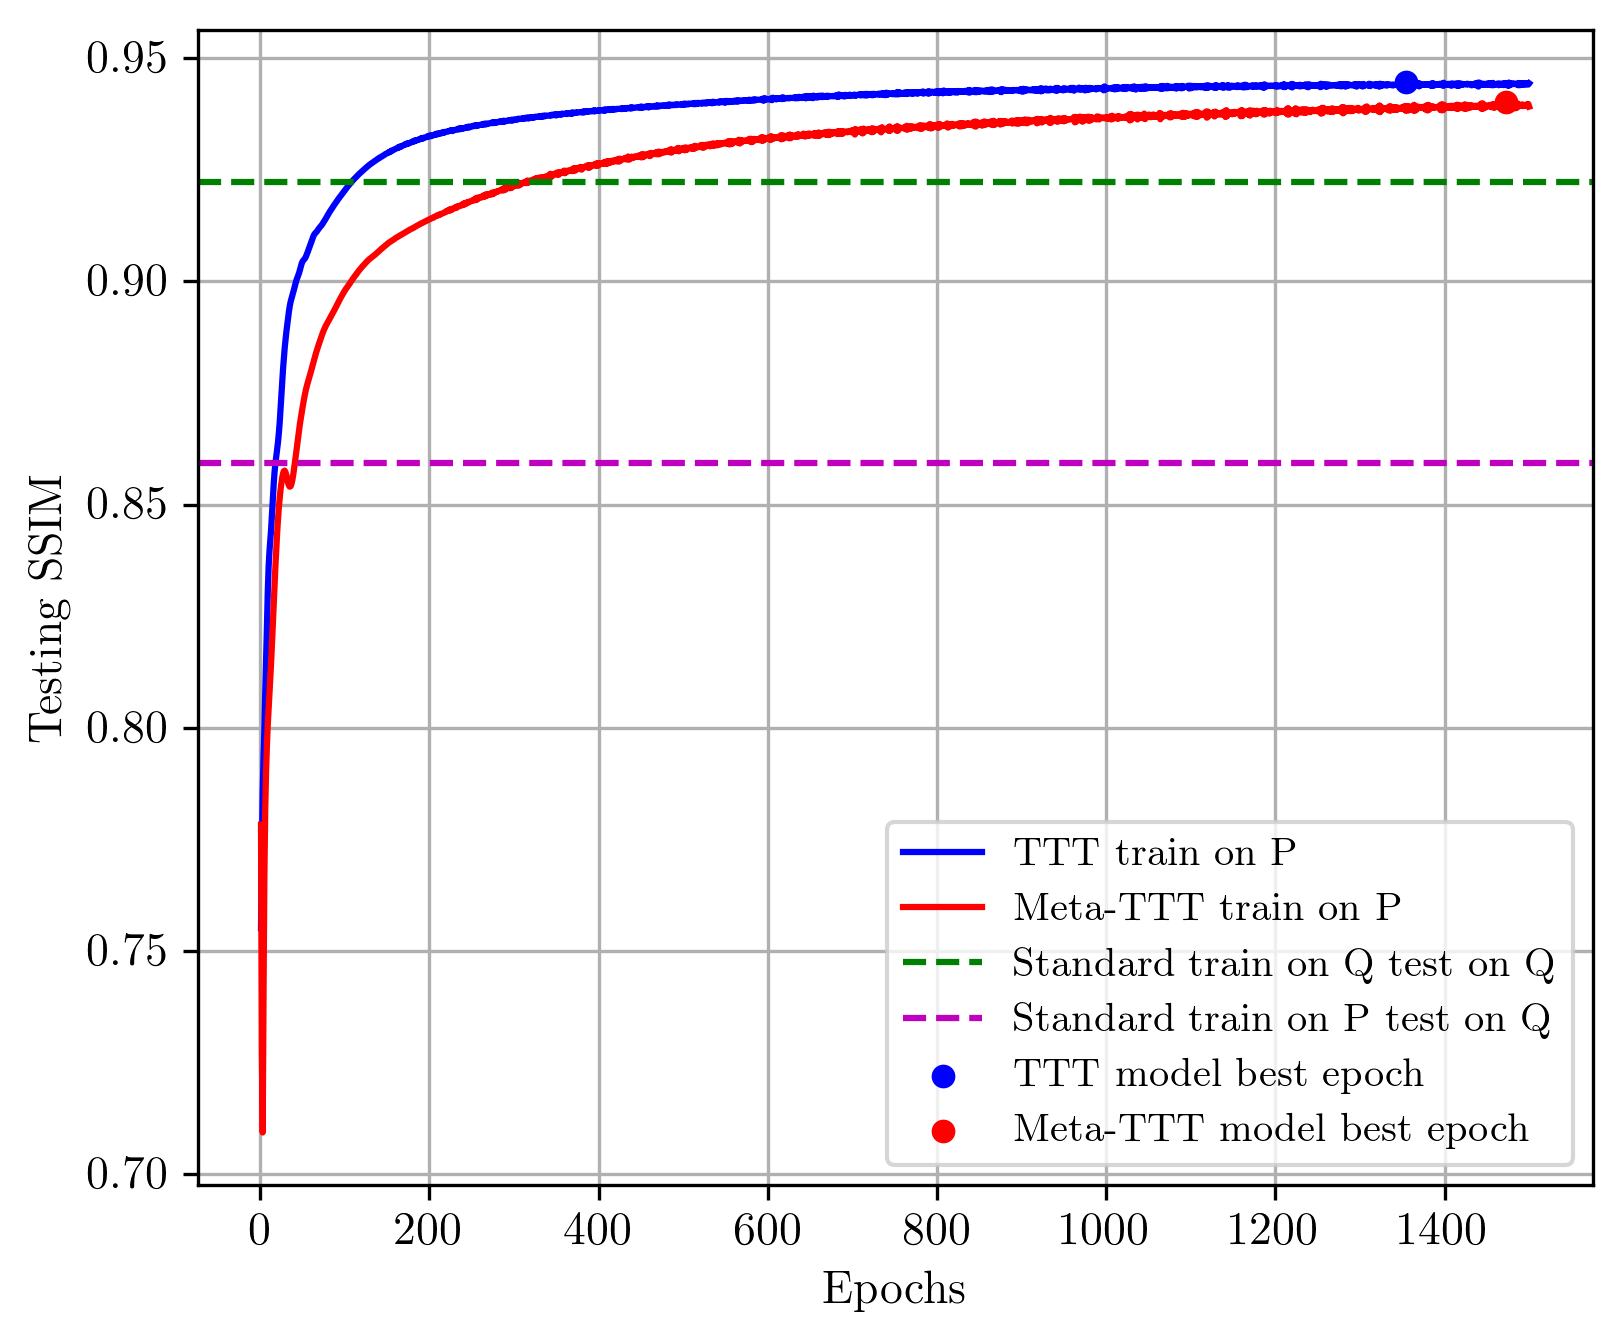

In [19]:
TTT_epoch = 1500
upper_bound = 0.9222 # not real
lower_bound = 0.8593 # not real

plt.figure(figsize=(6,5),dpi=300)
plt.grid(True, zorder=1)    # grid on bottom
# alpha: transparency 
plt.plot(range(1, TTT_epoch+1), loss_ssim_history, color=colors[0], label='TTT train on P')
plt.plot(range(1, TTT_epoch+1), loss_ssim_history_meta, color=colors[1], label='Meta-TTT train on P ')

plt.axhline(y = upper_bound, color=colors[3], linestyle='--', label='Standard train on Q test on Q ')   # upper bound
# plt.text(x=850, y=upper_bound+0.005, s='upper bound', color=colors[2])
plt.axhline(y = lower_bound, color=colors[4], linestyle='--', label='Standard train on P test on Q ')   # upper bound

plt.scatter(best_loss_ssim_epoch, loss_ssim_history[best_loss_ssim_epoch], color=colors[0], s=FONTSIZE, label = 'TTT model best epoch', zorder=2)
plt.scatter(best_loss_ssim_epoch_meta, loss_ssim_history_meta[best_loss_ssim_epoch_meta], color=colors[1], s=FONTSIZE, label = 'Meta-TTT model best epoch', zorder=2)

plt.tick_params(axis='both', which='major', labelsize=FONTSIZE/2)
plt.tick_params(axis='both', which='minor', labelsize=(FONTSIZE-2)/2)
plt.xlabel('Epochs',fontsize=FONTSIZE/2)
plt.ylabel('Testing SSIM',fontsize=FONTSIZE/2)
#plt.title('Out-of-distribution Q3 Adaptation', fontsize = FONTSIZE/2)
plt.legend(fontsize = (FONTSIZE-3)/2)

plt.show()

In [20]:
checkpoint_path_meta = '/cheng/metaMRI/metaMRI/save/E12.1_maml(l1_-5)P_T300_300epoch/E12.1_maml(l1_-5)P_T300_300epoch_E100.pth'
model_meta = Unet(in_chans=2, out_chans=2, chans=64, num_pool_layers=4, drop_prob=0.0)
model_meta.load_state_dict(torch.load(checkpoint_path_meta))
model_meta = model_meta.to(device)
self_loss_history_meta, loss_ssim_history_meta, best_loss_ssim_epoch_meta = TTT(model_meta, origk, sens_maps)

The best SSIM through training process: 0.9400243759155273
The best SSIM epoch:  1487


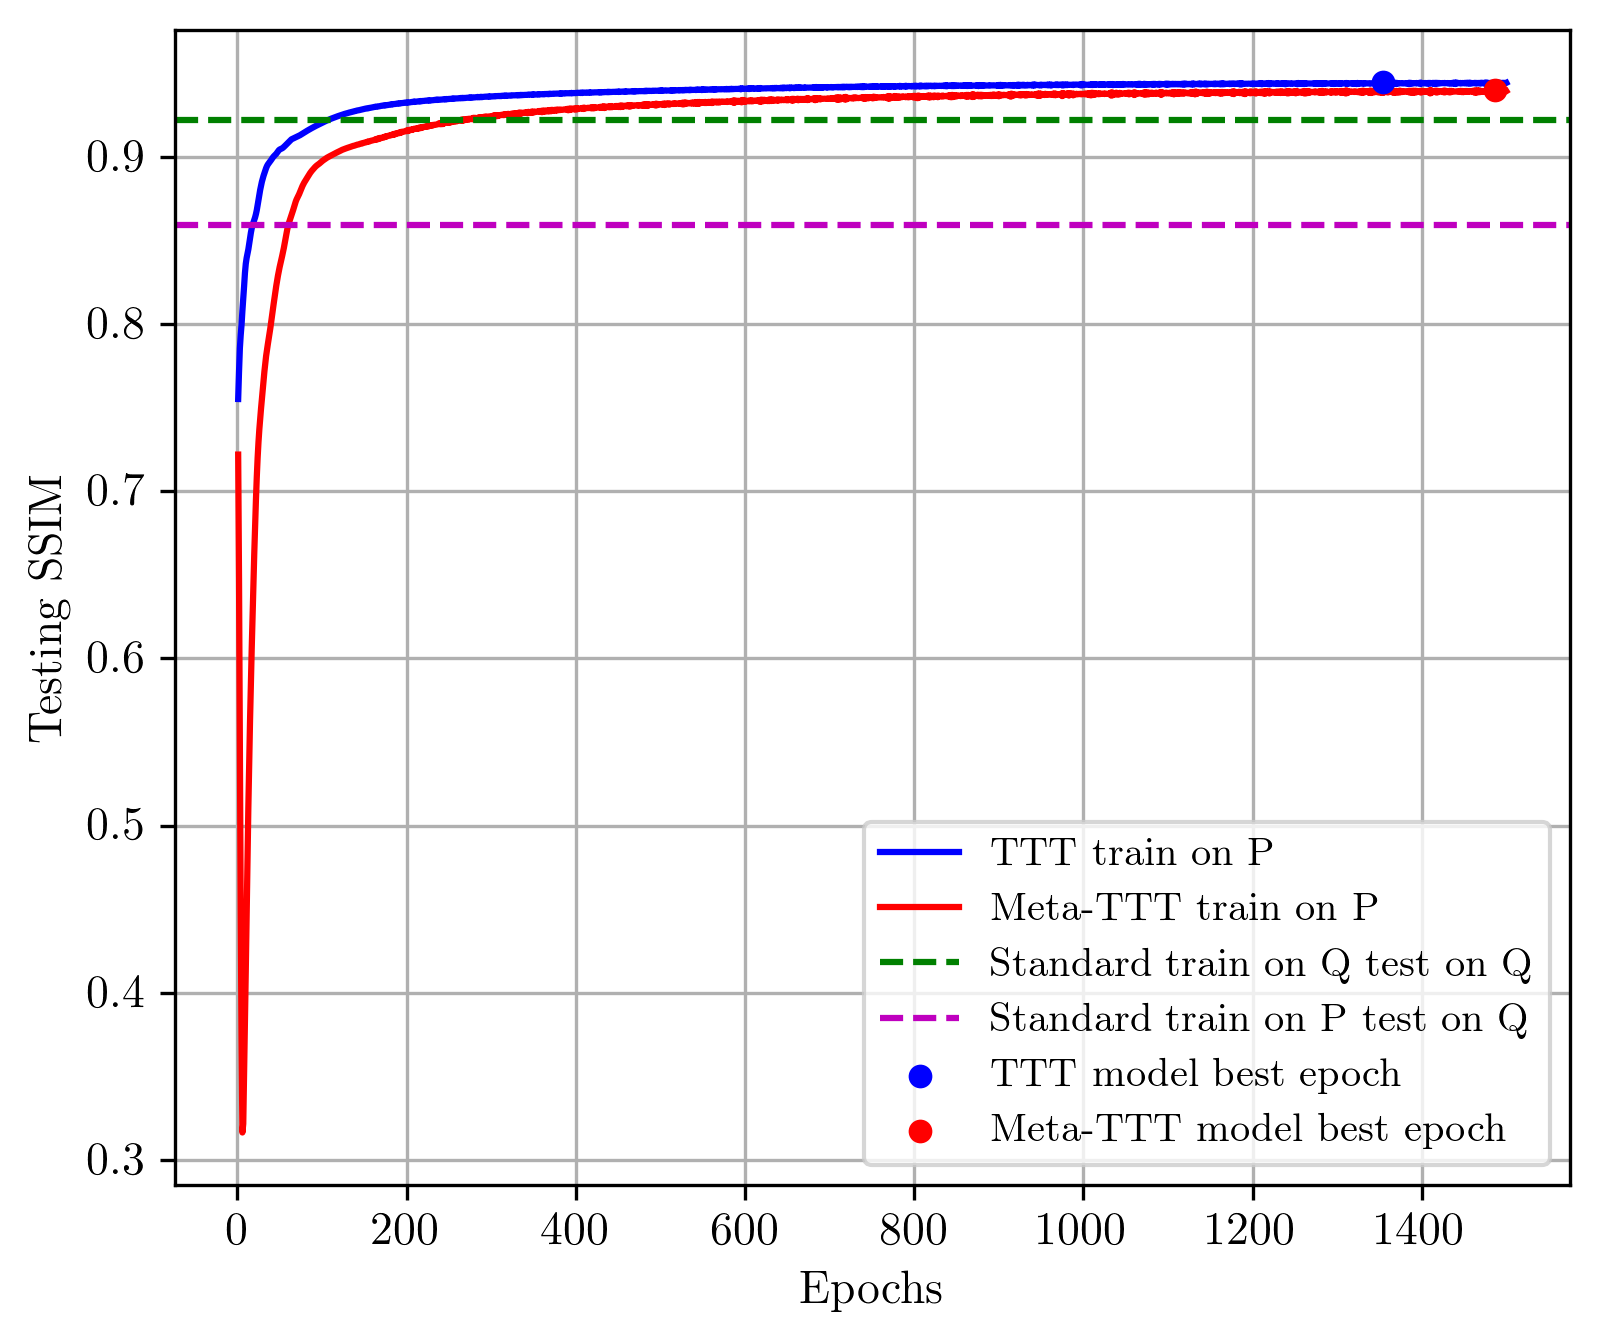

In [22]:
TTT_epoch = 1500
upper_bound = 0.9222 # not real
lower_bound = 0.8593 # not real

plt.figure(figsize=(6,5),dpi=300)
plt.grid(True, zorder=1)    # grid on bottom
# alpha: transparency 
plt.plot(range(1, TTT_epoch+1), loss_ssim_history, color=colors[0], label='TTT train on P')
plt.plot(range(1, TTT_epoch+1), loss_ssim_history_meta, color=colors[1], label='Meta-TTT train on P ')

plt.axhline(y = upper_bound, color=colors[3], linestyle='--', label='Standard train on Q test on Q ')   # upper bound
# plt.text(x=850, y=upper_bound+0.005, s='upper bound', color=colors[2])
plt.axhline(y = lower_bound, color=colors[4], linestyle='--', label='Standard train on P test on Q ')   # upper bound

plt.scatter(best_loss_ssim_epoch, loss_ssim_history[best_loss_ssim_epoch], color=colors[0], s=FONTSIZE, label = 'TTT model best epoch', zorder=2)
plt.scatter(best_loss_ssim_epoch_meta, loss_ssim_history_meta[best_loss_ssim_epoch_meta], color=colors[1], s=FONTSIZE, label = 'Meta-TTT model best epoch', zorder=2)

plt.tick_params(axis='both', which='major', labelsize=FONTSIZE/2)
plt.tick_params(axis='both', which='minor', labelsize=(FONTSIZE-2)/2)
plt.xlabel('Epochs',fontsize=FONTSIZE/2)
plt.ylabel('Testing SSIM',fontsize=FONTSIZE/2)
#plt.title('Out-of-distribution Q3 Adaptation', fontsize = FONTSIZE/2)
plt.legend(fontsize = (FONTSIZE-3)/2)

plt.show()